---
# Collective Anomalies  
<img src="../img/collective.png" width="400">

Occur when a record is anomalous when considered with adjacent records. This is prevalent in time-series data where a set of consecutive records are anomalous compared to the rest of the dataset

<img src="../img/collective2.png" width="800">

--- 
# Low-Pass Statistical Filter

## Anomalies on sunspots

The file has 3,143 rows, which contain information about sunspots collected between the years 1749-1984. Sunspots are defined as dark spots on the surface of the sun. The study of sunspots helps scientists understand the sun's properties over a period of time; in particular, its magnetic properties.

In [2]:
import pandas as pd
df = pd.read_csv("../datasets/sunspots.csv", sep='\t')

In [3]:
df.head()

,month,sunspots
0,0,58.0
1,1,62.6
2,2,70.0
3,3,55.7
4,4,85.0


In [1]:
import numpy as np
from itertools import count
from pandas.core.window import Rolling
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

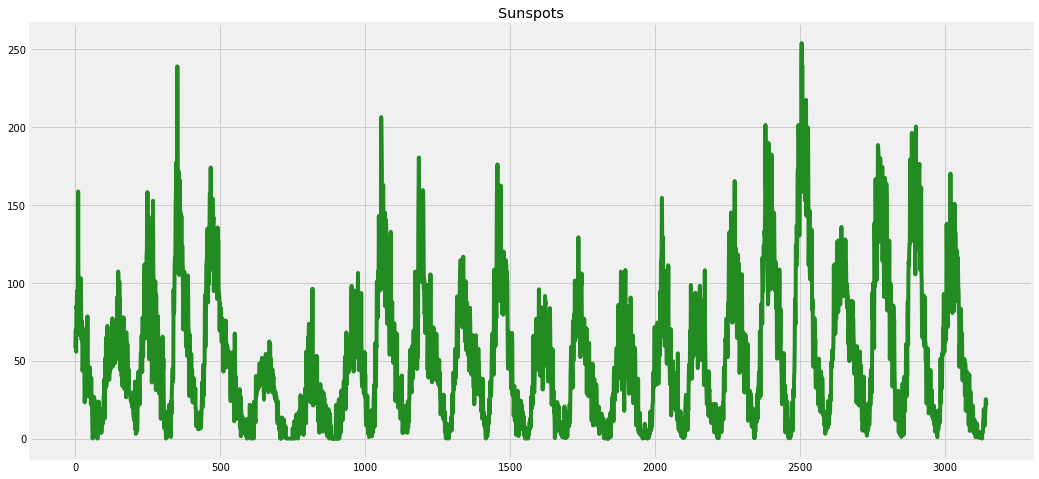

In [4]:
plt.figure(figsize=(16, 8))
plt.title("Sunspots")
plt.plot(range(len(df)), df['sunspots'], '-', c='forestgreen')

### Moving Average Using Discrete Linear Convolution

In [5]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [6]:
def explain_anomalies(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': {index: y_i for index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))}}

In [7]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = list(avg)#.tolist()
    residual = y - avg
    testing_std = Rolling(residual, window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = list(testing_std_as_df.replace(np.nan, testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0])#.tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': {index: y_i for index, y_i, avg_i, rs_i in zip(count(), y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))}}

In [8]:
# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1, text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.", alpha=0.4, c='blue')
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, len(y))
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.scatter(x_anomaly, y_anomaly, s=50, c='red')
    plt.grid(True)
    plt.show()

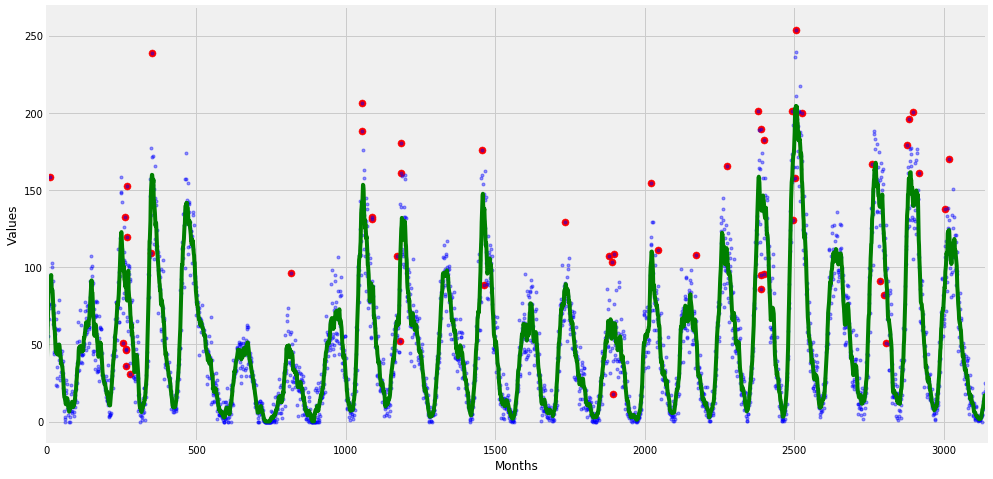

In [9]:
plot_results(range(len(df.index)), 
             y=df['sunspots'], 
             window_size=10, 
             text_xlabel="Months", 
             sigma_value=3, 
             text_ylabel="Values")

In [10]:
events = explain_anomalies(df['sunspots'], window_size=5, sigma=3)

print("Information about the anomalies model: {}".format(events.keys()))

Information about the anomalies model: dict_keys(['standard_deviation', 'anomalies_dict'])


In [11]:
events['anomalies_dict']

{10: 158.6,
 253: 142.5,
 255: 51.0,
 262: 132.2,
 264: 36.0,
 268: 152.7,
 278: 31.1,
 349: 109.3,
 352: 238.9,
 361: 165.7,
 818: 96.2,
 986: 93.4,
 1055: 206.3,
 1069: 84.8,
 1172: 107.1,
 1182: 52.2,
 1185: 180.4,
 1464: 88.3,
 1735: 129.2,
 1882: 107.2,
 1890: 103.6,
 1897: 108.2,
 2023: 154.5,
 2025: 72.2,
 2027: 129.3,
 2171: 108.0,
 2274: 165.3,
 2380: 201.3,
 2390: 94.8,
 2391: 189.7,
 2503: 158.0,
 2518: 152.3,
 2520: 217.4,
 2521: 143.1,
 2527: 199.6,
 2755: 58.1,
 2756: 138.2,
 2789: 90.9,
 2807: 127.0,
 2885: 196.2,
 2886: 126.9,
 2897: 105.4,
 2899: 200.3,
 3005: 137.7,
 3018: 170.1,
 3032: 150.7}

In [12]:
events_std = explain_anomalies_rolling_std(df['sunspots'], window_size=5, sigma=3)

print("Information about the anomalies model:{}".format(events_std))

Information about the anomalies model:{'stationary standard_deviation': 11.424, 'anomalies_dict': {872: 4.4, 889: 0.0, 1902: 49.7}}
